# Twitter Bot Classifier Part 3

In this series of notebooks, we are using the [Fake Project](https://botometer.iuni.iu.edu/bot-repository/datasets.html) dataset to examine users habits and build a Twitter bot classifier. 
 
Previously, we looked into the potential threats that Twitter bot accounts pose. While some are harmless, others aim to manipulate and deceive viewers. We gathered several Twitter files from the Fake Project to assemble a Tweets and Users datasets. Null values have been dropped and tables have been formatted. Now, we will take a closer look into the features by conducting exploratory data analysis. 


In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

#NLP tools
import string
import re
import nltk
from nltk.corpus import stopwords
from googletrans import Translator

# NLP feature selection 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score,accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Reduce Dimension 
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Clustering 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Math 
import math

# Datetime
from datetime import datetime
from dateutil import parser

# Import data
import warnings

In [2]:
tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_tweets2')
users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_users2')

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               object
timestamp                object
crawled_at               object
updated                  object
class                    int64
dtypes: int64(12), object(6)
memory usage: 862.9+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

### Convert time variables to datetime 
It doesn't appear that time variables such as timestamp or created_at were saved as datetime. We will convert them to their respective data type. 

In [5]:
# Convert the time columns to np.datetime object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

In [6]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [7]:
tweets['crawled_at'] = pd.to_datetime(tweets['crawled_at'])

In [8]:
tweets['updated'] = pd.to_datetime(tweets['updated'])

In [9]:
# Convert the created_at column to np.datetime object
users['timestamp'] = pd.to_datetime(users['timestamp'])

In [10]:
users['created_at'] = pd.to_datetime(users['created_at'])

In [11]:
users['crawled_at'] = pd.to_datetime(users['crawled_at'])

In [12]:
users['updated'] = pd.to_datetime(users['updated'])

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               datetime64[ns, UTC]
timestamp                datetime64[ns]
crawled_at               datetime64[ns]
updated                  datetime64[ns]
class                    int64
dtypes: datetime64[ns, UTC](1), datetime64[ns](3), int64(12), object(2)
memory usage: 862.9+ MB


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

In [15]:
tweets.head()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
0,515447020405137408,"""Il mare d'inverno è un concetto che il pensie...","<a href=""http://www.Matildadr89.com"" rel=""nofo...",237359828,0,0,0,0,0,0,0,0,0,2014-09-26 10:25:20+00:00,2014-09-26 12:25:20,2014-11-13 01:35:24,2014-11-13 01:35:24,1
1,513551196226093057,Read the History of Corona Beer http://t.co/Z...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",215693377,0,0,0,0,0,0,0,1,0,2014-09-21 04:52:01+00:00,2014-09-21 06:52:01,2014-11-12 23:35:05,2014-11-12 23:35:05,1
2,579534763872149504,After that it would of been up to the person i...,"<a href=""http://twitter.com/download/iphone"" r...",164284493,0,0,0,0,0,0,0,0,0,2015-03-22 06:47:09+00:00,2015-03-22 07:47:09,2015-05-01 13:21:46,2015-05-01 13:21:46,0
3,449751137970028544,RT @kcivey: @marionbarryjr I'm for public fina...,"<a href=""http://twitter.com/download/iphone"" r...",225683965,0,0,449735142085779456,1,0,0,0,0,2,2014-03-29 03:33:21+00:00,2014-03-29 04:33:21,2015-05-01 15:58:20,2015-05-01 15:58:20,0
4,589197488269045760,RT @specuIar: This hit me hard. http://t.co/rY...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",505440359,0,0,589196377353097216,1300,0,0,0,0,1,2015-04-17 22:43:22+00:00,2015-04-18 00:43:22,2015-05-01 13:21:33,2015-05-01 13:21:33,0


In [16]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,created_at,timestamp,crawled_at,updated,class
0,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-18 11:22:38+00:00,2014-02-18 12:22:38,2014-05-03 00:22:39,2016-03-15 15:20:24,1
1,343263643,RIP Teveon ,youpettihoe_,36513,2166,1627,2977,0,en,http://pbs.twimg.com/profile_images/5594447898...,...,FFFFFF,FFFFFF,http://pbs.twimg.com/profile_background_images...,FFFAFF,0A7A00,2011-07-27 09:01:04+00:00,2011-07-27 11:01:04,2015-05-01 23:18:23,2016-03-15 16:11:13,0
2,531154412,Bulah Lynne,Lynnevibe,10657,1194,996,1,8,en,http://pbs.twimg.com/profile_images/1914097815...,...,C0DEED,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,2012-03-20 11:48:05+00:00,2012-03-20 12:48:05,2014-05-05 23:24:32,2016-03-15 15:40:08,1
3,2377665366,Katherina Kistle,KatherinaKistle,37,0,38,0,0,en,http://pbs.twimg.com/profile_images/4430041788...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-03-07 21:23:35+00:00,2014-03-07 22:23:35,2014-05-05 00:21:50,2016-03-15 15:16:15,1
4,3015346510,Lindsay Blessing Fan,lindsayspainfan,96,43,113,425,0,es,http://pbs.twimg.com/profile_images/5631073115...,...,000000,000000,http://pbs.twimg.com/profile_background_images...,000000,9266CC,2015-02-03 20:49:38+00:00,2015-02-03 21:49:38,2015-05-02 01:09:46,2016-03-15 16:07:16,0


## Exploratory Data Analysis
We'll start by exploring the Tweets table by keeping a few questions in mind.<br> 
__How many tweets were made by humans and robots?__ <br>
__Which accounts posted the most tweets?__ <br>

 Plot scatter account age by tweets, hue= class 
 Tweet more than 3k 
 violin or boxplot user by retweets vs. age of account per class

In [17]:
# Bot vs human tweets 
counts = users['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} genuine accounts({:.3f}%) and {} spambot accounts ({:.3f}%) in the users table.'.format(human, human_per, bot, bot_per))

There are 3083 genuine accounts(38.591%) and 4906 spambot accounts (61.409%) in the users table.


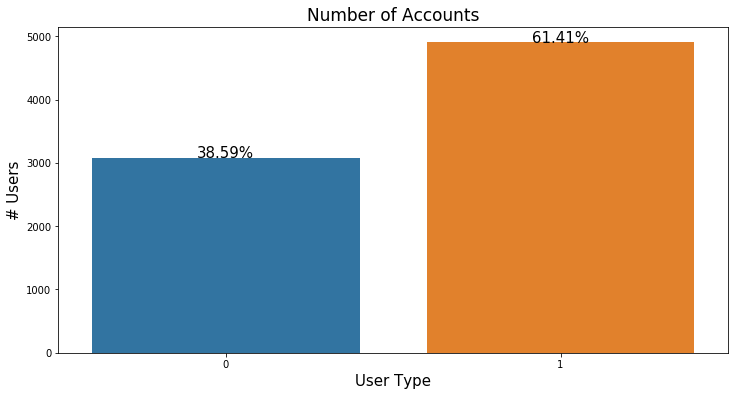

In [18]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = users)
g.set_title('Number of Accounts', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Users', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(users) * 100),
            ha="center", fontsize=15) 

## Correlation
We'll start by exmaining the correlation between features and target varaible. 

In [19]:
# Find correlations with the target and sort
corr = users.corr()['class'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 statuses_count                 -0.355780
favourites_count               -0.291933
listed_count                   -0.081320
followers_count                -0.031655
friends_count                  -0.012698
id                              0.441920
class                           1.000000
profile_use_background_image         NaN
Name: class, dtype: float64

Most Negative Correlations:
 statuses_count                 -0.355780
favourites_count               -0.291933
listed_count                   -0.081320
followers_count                -0.031655
friends_count                  -0.012698
id                              0.441920
class                           1.000000
profile_use_background_image         NaN
Name: class, dtype: float64


In [20]:
# Correlation 
top_feat = np.absolute(users.corr()['class']).sort_values(ascending=False)[:11]
top_feat

class                           1.000000
id                              0.441920
statuses_count                  0.355780
favourites_count                0.291933
listed_count                    0.081320
followers_count                 0.031655
friends_count                   0.012698
profile_use_background_image         NaN
Name: class, dtype: float64

__Observation__: The correlation between our target variable and the top features are rather week. The highest correlation is about 32%. Let's look at the pairplot for the top 10 features.

In [21]:
# Top 10 features
print(top_feat.index)

Index(['class', 'id', 'statuses_count', 'favourites_count', 'listed_count',
       'followers_count', 'friends_count', 'profile_use_background_image'],
      dtype='object')


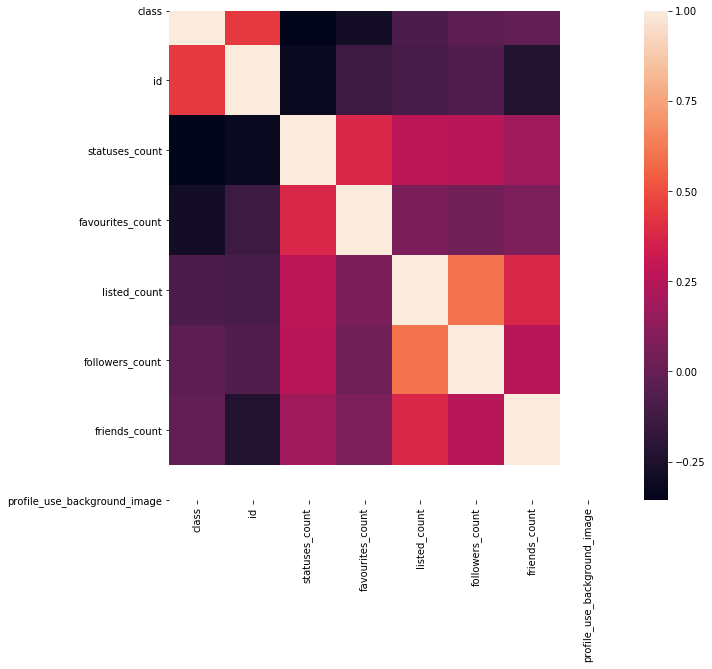

In [22]:
pp = users[top_feat.index]
plt.figure(figsize=(10,9))
corr = pp.corr()
sns.heatmap(corr)
plt.savefig('heatmat.png')

__Observation__: V columns are Vesta featured engineered. Multiple columns show high correlation with each other. These columns probably derive from the same original variables. 

## Merge User and Tweet Tables

In [23]:
users.rename(columns ={'id': 'user_id'}, inplace =True)
df = pd.merge(users, tweets,  how='inner', on=['user_id'] )

In [24]:
df.head()

,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at_y,timestamp_y,crawled_at_y,updated_y,class_y
0,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-26 18:56:00+00:00,2014-04-26 20:56:00,2014-11-13 01:44:20,2014-11-13 01:44:20,1
1,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-29 02:19:20+00:00,2014-04-29 04:19:20,2014-11-13 01:44:20,2014-11-13 01:44:20,1
2,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,1,2014-06-20 21:48:08+00:00,2014-06-20 23:48:08,2014-11-13 01:44:20,2014-11-13 01:44:20,1
3,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-29 02:18:48+00:00,2014-04-29 04:18:48,2014-11-13 01:44:20,2014-11-13 01:44:20,1
4,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,0,0,0,0,0,2014-04-28 18:37:26+00:00,2014-04-28 20:37:26,2014-11-13 01:44:20,2014-11-13 01:44:20,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5968328 entries, 0 to 5968327
Data columns (total 41 columns):
user_id                               int64
name                                  object
screen_name                           object
statuses_count                        int64
followers_count                       int64
friends_count                         int64
favourites_count                      int64
listed_count                          int64
lang                                  object
profile_image_url                     object
profile_use_background_image          int64
profile_background_image_url_https    object
profile_text_color                    object
profile_image_url_https               object
profile_sidebar_border_color          object
profile_sidebar_fill_color            object
profile_background_image_url          object
profile_background_color              object
profile_link_color                    object
created_at_x                          d

In [27]:
# Drop unwanted columns 
df = df.drop(columns=['id','created_at_y', 'timestamp_y', 'crawled_at_y', 'updated_y','class_y'])

In [28]:
df.rename(columns ={'created_at_x': 'created_at','timestamp_x':'timestamp',
                    'crawled_at_x':'crawled_at','updated_x':'updated','class_x':'class'}, inplace =True)

In [29]:
df.columns

Index(['user_id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'lang',
       'profile_image_url', 'profile_use_background_image',
       'profile_background_image_url_https', 'profile_text_color',
       'profile_image_url_https', 'profile_sidebar_border_color',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'created_at',
       'timestamp', 'crawled_at', 'updated', 'class', 'text', 'source',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
       'retweet_count', 'reply_count', 'favorite_count', 'num_hashtags',
       'num_urls', 'num_mentions'],
      dtype='object')

In [30]:
# Replace field that's entirely space (or empty) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# Check for null values 
df.isnull().sum().sum()

In [ ]:
# Drop rows with NaN values
df = df.dropna(inplace=True)

# Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will use our findings to select a set of features for our model. 

For this assignment, we will take the following steps for feature selection:
 * creating new variables by aggregation
 * dropping unwanted varaibles
 * encode for tweets

In [ ]:
# Function to calculate the age of the account given creation time
def calculate_age(created_at):
    today = datetime.now()
    return today.year - created_at.year 

In [ ]:
# Create new features 
df['account_age_yr'] = df['created_at'].apply(lambda x: calculate_age(x))
df['digit_in_name'] = df['screen_name'].apply(lambda x: sum(c.isdigit() for c in x))
df['user_name_len'] = df['screen_name'].apply(len)
df['tweet_len'] = df['text'].apply(len)

In [ ]:
# Plot age of accounts 
g = sns.countplot(x='account_age_yr', hue= 'class',data=df)
g.set_title('Count of Account Age', fontsize = 17)
g.set_xlabel('Account Age (YR)', fontsize = 15)
g.set_ylabel('Count of Users', fontsize = 15)
plt.legend(loc='upper right')

__Observation__: As shown in the graph, this dataset consists of accounts that age 5 years or older. Most of the spam accounts were created in 2014. 

In [ ]:
# Tweet length


In [ ]:
df

In [ ]:
# Drop unwanted columns 
df_tweets = df_tweets.drop(columns=['index','id','text','source','user_id','created_at', 'timestamp', 'crawled_at', 'updated','clean_tweets'])

In [ ]:
df_tweets.columns

In [ ]:
df_tweets.shape

In [ ]:
# Check for null values 
df_tweets.isnull().sum().sum()

# Evaluating and Comparing Machine Learning Models
In this section we will build, train, and evalute several machine learning methods for our supervised regression task.

## Split Train and Test set¶
Let's split dataset by using function train_test_split(). Here, the Dataset is broken into two parts in a ratio of 70:30. It means 70% data will be used for model training and 30% for model testing.

To continue feature selection, we will start by using the original attributes in the raw training set.

In [ ]:
# Set variables 
y = df_tweets['class']
X = df_tweets.drop(columns=['class'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Metric 
We will evaluate our models based on their predicted probability __ROC AUC score__. ROC AUC "summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds"[Brownlee](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

We’ll also focus on the __false positive rate__(FPR) and __false negative rate__(FNR). False positive rate is identifying genuine tweets as robot tweets. This could lead to disregarding value customer behavior information which can provide misleading data for future marketing campaigns and lower customer satisfaction. False negative rate is failure to label true robot tweets as bots tweets, which results in obtaining false customer information. 

FPR and FNR are reflected in the following metrics: 

 * __Accuracy__: ratio of properly labeled accounts 

 * __Precision__: ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all tweets that are labeled as bots, how many are actually bots? High precision relates to the low false positive rate. 

 * __Recall (Sensitivity)__: ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the tweets that were genereated by bots, how many did we label? 

 
# Model  Selection

We will compare three different machine learning models:

1. Logistic Regression
2. Random Forest Classifer
3. Neural Network Classifer 

We will fit these models the appropiate training set.

## Baseline 
For a naive baseline, we will use logistic regression to predict the probability of an user account being a robot. Unlike linear regression which gives continuous output, logistic regression provides a constant output in predicting binary classes. If the probability 'p' is greater than 0.5, the data is labeled '1'. Probability less than 0.5 is labeled as '0'.

## Logistic Regression 
First, we'll create the model and train the model and make predictions on the testing data.

# Modeling

In [ ]:
# Function to plot ROC curve 
def roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred_proba2 = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba)
    fpr2, tpr2, thresholds = metrics.roc_curve(y_test, y_pred_proba2)

    model_auc = metrics.roc_auc_score(y_train, y_pred_proba)
    model_auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="Train, auc="+str(model_auc))
    ax.plot(fpr2, tpr2, label="Test, auc="+str(model_auc2))

    plt.title('ROC curve')
    ax.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [ ]:
# Logistic Regression Model 
lr = LogisticRegression()

# Fit and predict 
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

# CV to check if overfitting 
print(cross_val_score(lr, X_train, y_train, cv=5))

In [ ]:
# Calculate metrics
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (lr_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (lr_accuracy * 100.0))
print('Recall: %.2f%%' % (lr_recall * 100.0))
print('Precision: %.2f%%' % (lr_precision * 100.0))
print(confusion_matrix(y_test, lr_y_pred))

In [ ]:
# Logistic Model
#parameters = {'C':np.logspace(-5,5)}
#lr = LogisticRegression()
#gsc_lr = GridSearchCV(lr, parameters, cv=5, scoring='roc_auc')
#gsc_lr.fit(X_train, y_train)
#print(gsc_lr.best_params_, gsc_lr.best_score_)

# {'C': 1e-05} 0.771215887401393

In [ ]:
# Optmizied Logistic Model
#parameters = {}
#parameters['penalty'] = ['l1', 'l2']
#gsc_lr2 = LogisticRegression(C=1e-05)
#gsc_lr2 = GridSearchCV(gsc_lr2, parameters, cv=5, scoring='roc_auc')
#gsc_lr2.fit(X_train, y_train)
#print(gsc_lr2.best_params_, gsc_lr2.best_score_)

# NOTE: Took too long to process 

### Optimized Logistic Regression Model 

In [ ]:
# Optimized Logistic Regression Model 
gsc_lr = LogisticRegression(C=1e-05)
gsc_lr.fit(X_train, y_train)
gsc_lr_y_pred = gsc_lr.predict(X_test)

In [ ]:
# Calculate metrics
gsc_lr_roc_auc = roc_auc_score(y_test, gsc_lr_y_pred)
gsc_lr_accuracy = accuracy_score(y_test, gsc_lr_y_pred)
gsc_lr_recall = recall_score(y_test, gsc_lr_y_pred)
gsc_lr_precision = precision_score(y_test, gsc_lr_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_lr_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_lr_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_lr_recall * 100.0))
print('Precision: %.2f%%' % (gsc_lr_precision * 100.0))
print(confusion_matrix(y_test, gsc_lr_y_pred))

In [ ]:
# Function to plot ROC curve 
roc_curve(gsc_lr, X_train, y_train, X_test, y_test)

__Evaluation__: The optimized logistic regression model has essentially the same AUC score of 0.853 on the training set. From the cross validation score, this model doesn't seem to be overfitting since the scores range between 0.84 to 0.86. The accuracy score is the same as the initial model, 77.64%. Since our primary metric is ROC AUC, we will continue with the initial logistic regression model since it has a slightly higher AUC score. 

### Random Forest 

In [ ]:
# Random Forest Model 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit and predict
rf.fit(X_train, y_train) 
rf_y_pred = rf.predict(X_test)

# Check if model is overfitting 
print(cross_val_score(rf, X_train, y_train, cv=5))

# Results: [0.98972443 0.98949089 0.9901915  0.9927587  0.99299065]

In [ ]:
# Calculate metrics
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (rf_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))
print('Recall: %.2f%%' % (rf_recall * 100.0))
print('Precision: %.2f%%' % (rf_precision * 100.0))
print(confusion_matrix(y_test, rf_y_pred))

#ROC_AUC: 99.20%
#Accuracy: 99.12%
#Recall: 98.43044928389249 %
#Precision: 99.98007174172977 %
#[[4077    1]
 #[  80 5017]]


In [ ]:
#Optimizing Random Forest
#parameters = {}
#parameters['criterion'] = ['entropy','gini']
#parameters['n_estimators'] = [100,200,300]

#gsc_rf = GridSearchCV(rf, parameters, cv=5, verbose=1, scoring='roc_auc')
#gsc_rf.fit(X_train, y_train)
#print(gsc_rf.best_params_, gsc_rf.best_score_)

# {'criterion': 'entropy', 'n_estimators': 300} 0.9993297513905806

### Optmized Random Forest

In [ ]:
# Optimized Random Forest
gsc_rf = RandomForestClassifier(n_estimators=300, criterion='entropy', random_state=42)
gsc_rf.fit(X_train, y_train) 
gsc_rf_y_pred = gsc_rf.predict(X_test)

In [ ]:
# Calculate metrics
gsc_rf_roc_auc = roc_auc_score(y_test, gsc_rf_y_pred)
gsc_rf_accuracy = accuracy_score(y_test, gsc_rf_y_pred)
gsc_rf_recall = recall_score(y_test, gsc_rf_y_pred)
gsc_rf_precision = precision_score(y_test, gsc_rf_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_rf_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_rf_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_rf_recall * 100.0))
print('Precision: %.2f%%' % (gsc_rf_precision * 100.0))
print(confusion_matrix(y_test, gsc_rf_y_pred))

#ROC_AUC: 99.23%
#Accuracy: 99.15%
#Recall: 98.50892681969786 %
#Precision: 99.96018315747561 %
#[[4076    2]
 #[  76 5021]]

In [ ]:
# Function to plot ROC curve 
roc_curve(gsc_rf, X_train, y_train, X_test, y_test)

__Evaluation__: The optimized logistic regression model has essentially the same AUC score of 0.853 on the training set. From the cross validation score, this model doesn't seem to be overfitting since the scores range between 0.84 to 0.86. The accuracy score is the same as the initial model, 77.64%. Since our primary metric is ROC AUC, we will continue with the initial logistic regression model since it has a slightly higher AUC score. 

### Model Interpretation: Feature Importances
For model interpretability, we will take a look at the feature importances of our optimized random forest. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
# Top N importances
N = 10
importances = gsc_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in gsc_rf.estimators_],
             axis=0)

# Create a dataframe
importances_df = pd.DataFrame({'Variable':X.columns, 'Importance': importances})

top_N = importances_df.sort_values(by=['Importance'], ascending=False).head(10)

top_N

In [ ]:
# Creating a bar plot
sns.barplot(y='Variable', x='Importance', data=top_N)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Random Forest Important Features")
plt.show()

__Observation__: Transaction amount and counting matches appears to be the most important features in detecting fraud. Our feature engineered variables also made it in the top ten with interactions between transaction amount and card information. 

Let's try to reduce the noise in the data by placing a threshold of 0.005 for feature importance. 

### Multi-Layer Preceptron Neural Network

In [ ]:
# Establish and fit the model
mlp = MLPClassifier(max_iter=100) 

# Fit and predict
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)

# Check for overfitting
print(cross_val_score(mlp, X_train, y_train, cv=5))
# Default param(hidden_layer_sizes: 100, activation: ‘relu’, solver: adam’, alpha: 0.0001, learning_rate: ‘constant’)

In [ ]:
# Calculate metrics
mlp_roc_auc = roc_auc_score(y_test, mlp_y_pred)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
mlp_recall = recall_score(y_test, mlp_y_pred)
mlp_precision = precision_score(y_test, mlp_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (mlp_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (mlp_accuracy * 100.0))
print('Recall: %.2f%%' % (mlp_recall * 100.0))
print('Precision: %.2f%%' % (mlp_precision * 100.0))
print(confusion_matrix(y_test, mlp_y_pred))

In [ ]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

gsc_mlp = GridSearchCV(mlp, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
gsc_mlp.fit(X_train, y_train)
print(gsc_mlp.best_params_, gsc_mpl.best_score_)

### Optimized MLP

In [ ]:
# Establish and fit the model
gsc_mlp = MLPClassifier(max_iter=100) 
gsc_mlp.fit(X_train, y_train)
gsc_mlp_y_pred = gsc_mlp.predict(X_test)

In [ ]:
# Calculate metrics
gsc_mlp_roc_auc = roc_auc_score(y_test, gsc_mlp_y_pred)
gsc_mlp_accuracy = accuracy_score(y_test, gsc_mlp_y_pred)
gsc_mlp_recall = recall_score(y_test, gsc_mlp_y_pred)
gsc_mlp_precision = precision_score(y_test, gsc_mlp_y_pred)

# Print metrics
print("ROC_AUC: %.2f%%" % (gsc_mlp_roc_auc * 100.0))
print("Accuracy: %.2f%%" % (gsc_mlp_accuracy * 100.0))
print('Recall: %.2f%%' % (gsc_mlp_recall * 100.0))
print('Precision: %.2f%%' % (gsc_rmlp_precision * 100.0))
print(confusion_matrix(y_test, gsc_mlp_y_pred))

In [ ]:
# Function to plot ROC curve 
roc_curve(gsc_mlp, X_train, y_train, X_test, y_test)

__Evaluation__: The optimized logistic regression model has essentially the same AUC score of 0.853 on the training set. From the cross validation score, this model doesn't seem to be overfitting since the scores range between 0.84 to 0.86. The accuracy score is the same as the initial model, 77.64%. Since our primary metric is ROC AUC, we will continue with the initial logistic regression model since it has a slightly higher AUC score.

## Supervised Learning Conclusion 

In [ ]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'Model': ['Linear Regression', 'Ridge Regression',
                                           'Lasso Regression', 'Elastic Net Regression'],
                                 'MAE': [lr_mae, rr_mae, lar_mae,er_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('MAE', ascending = True)

#### Which model performed best?
As we can see, all the models performed fairly simiular in terms of accuracy. The average accuracy of the models ranges from 88% to 89%. Based on the MAE, ridge regression had the least amount of error prediction so we will continue with using this model. 

## Unsupervised Learning 

In [ ]:
X = users.loc[:,['statuses_count','followers_count','friends_count','favourites_count','listed_count']]
y = users['class']

### K-means clustering

In [ ]:
from sklearn.preprocessing import normalize
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

## Mean-shift Clustering

In [ ]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_svd, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_svd)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

In [ ]:
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))